In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from sklearn.model_selection import train_test_split
import feature_engine.transformation as vt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

# the scaler - for min-max scaling
from sklearn.preprocessing import MinMaxScaler

In [31]:
data_fifa_new = pd.read_csv('data/fifa_cleaned.csv')

In [32]:
data_fifa_new.columns

Index(['age', 'height_cm', 'weight_kg', 'overall', 'potential', 'value_eur',
       'wage_eur', 'preferred_foot', 'weak_foot', 'skill_moves', 'work_rate',
       'team_position', 'gk_diving', 'gk_handling', 'gk_kicking',
       'gk_reflexes', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking', 'defending_standing_tackle',
       'defending_sliding_tackle', 'goalkeeping_diving',
       'goalkeeping

In [33]:
# based on the feature selection method we will remove some independent features which are highly correlated with eachother.

drop_feature = ['gk_diving','gk_handling','gk_kicking','gk_reflexes','defending_marking','attacking_crossing','attacking_finishing','attacking_short_passing','attacking_volleys','defending_median','defending_sliding_tackle',
'defending_standing_tackle','dribbling_median','goalkeeping_diving','goalkeeping_handling','goalkeeping_kicking','goalkeeping_positioning',
'goalkeeping_reflexes','mentality_aggression','mentality_composure','mentality_interceptions','mentality_penalties','mentality_positioning',
'mentality_vision','movement_acceleration','movement_agility','movement_balance','movement_sprint_speed','passing_median','physic_median',
'power_long_shots','power_shot_power','power_stamina','shooting_median','skill_ball_control','skill_curve','skill_dribbling','skill_fk_accuracy',
'skill_long_passing','wage_eur','weight_kg']

for feature in range(len(drop_feature)):
    data_fifa_new = data_fifa_new.drop([drop_feature[feature]], axis=1)

In [34]:
data_fifa_new.columns

Index(['age', 'height_cm', 'overall', 'potential', 'value_eur',
       'preferred_foot', 'weak_foot', 'skill_moves', 'work_rate',
       'team_position', 'attacking_heading_accuracy', 'movement_reactions',
       'power_jumping', 'power_strength', 'pace_median'],
      dtype='object')

In [36]:
# numerical and categorical features

numerical_features = [feature for feature in data_fifa_new.columns if data_fifa_new[feature].dtype != 'O']
categorical_feature = [feature for feature in data_fifa_new.columns if data_fifa_new[feature].dtype == 'O']

# print columns
print('We have {} numerical features : {}'.format(len(numerical_features), numerical_features))
print('We have {} categorical features : {}'.format(len(categorical_feature), categorical_feature))

We have 13 numerical features : ['age', 'height_cm', 'overall', 'potential', 'value_eur', 'preferred_foot', 'weak_foot', 'skill_moves', 'attacking_heading_accuracy', 'movement_reactions', 'power_jumping', 'power_strength', 'pace_median']
We have 2 categorical features : ['work_rate', 'team_position']


In [37]:
# lets move towards splitting the data.

# get the locations
y = data_fifa_new['overall']
X = data_fifa_new.drop(columns=['overall'], axis=1)

In [38]:
# create a column transformer with 3 types of transformer

num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, cat_features),
        ("StandardScaler", numeric_transformer, num_features),
    ]
)

In [39]:
X = preprocessor.fit_transform(X)

In [40]:
X.shape

(18944, 51)

In [41]:
# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((15155, 51), (3789, 51))

#### Create an Evaluation function to give all metrics afte model training

In [42]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [43]:
models = {
    "Linear Regression" : LinearRegression(),
    "Lasso" : Lasso(),
    "Ridge" : Ridge(),
    "Random Forest Regressor" : RandomForestRegressor(),
    "XGBRegressor" : XGBRegressor(),
    "CatBoosting Regressor" : CatBoostRegressor(verbose = False),
    "AdaBoost Regressor" : AdaBoostRegressor()
}

model_list = []
r2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train)

    # make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate train and test set
    model_train_mae, model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)
    model_test_mae, model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])

    print("model performance for training dataset")
    print("- Root mean Sqared Error: {:.4f}".format(model_train_rmse))
    print("- mean absolute Error: {:.4f}".format(model_train_mae))
    print("- r2 score: {:.4f}".format(model_train_r2))
    r2_list.append(model_train_r2)

    print("-----------------------------------------------------")

    print("Model performace on test dataset")
    print("- Root mean Sqared Error: {:.4f}".format(model_test_rmse))
    print("- mean absolute Error: {:.4f}".format(model_test_mae))
    print("- r2 score: {:.4f}".format(model_test_r2))  
    r2_list.append(model_test_r2)


    print("="*35)
    print('\n')

Linear Regression
model performance for training dataset
- Root mean Sqared Error: 2.0457
- mean absolute Error: 1.5705
- r2 score: 0.9155
-----------------------------------------------------
Model performace on test dataset
- Root mean Sqared Error: 2.0468
- mean absolute Error: 1.5702
- r2 score: 0.9111


Lasso
model performance for training dataset
- Root mean Sqared Error: 2.8519
- mean absolute Error: 2.2469
- r2 score: 0.8357
-----------------------------------------------------
Model performace on test dataset
- Root mean Sqared Error: 2.8452
- mean absolute Error: 2.2365
- r2 score: 0.8283


Ridge
model performance for training dataset
- Root mean Sqared Error: 2.0457
- mean absolute Error: 1.5704
- r2 score: 0.9155
-----------------------------------------------------
Model performace on test dataset
- Root mean Sqared Error: 2.0471
- mean absolute Error: 1.5700
- r2 score: 0.9111


Random Forest Regressor
model performance for training dataset
- Root mean Sqared Error: 0.152

In [44]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name','R2_Score']).sort_values(by=['R2_Score'], ascending=False)

,Model Name,R2_Score
6,AdaBoost Regressor,0.999533
0,Linear Regression,0.915459
4,XGBRegressor,0.915455
1,Lasso,0.911120
5,CatBoosting Regressor,0.911094
2,Ridge,0.835697
3,Random Forest Regressor,0.828251


# Linear Regression

In [45]:
lin_model = LinearRegression(fit_intercept=True)
lin_model = lin_model.fit(X_train, y_train)
y_pred = lin_model.predict(X_test)
score = r2_score(y_test, y_pred)*100
print("Accuracy of the model is %.2f" %score)

Accuracy of the model is 91.11


# Plot y_pred and y_test

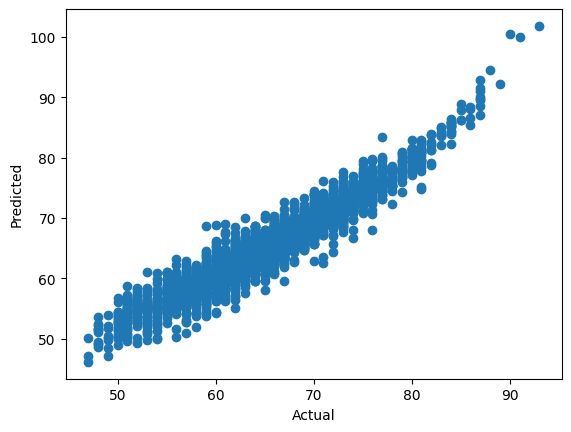

In [46]:
plt.scatter(y_test, y_pred);
plt.xlabel('Actual');
plt.ylabel('Predicted');

<Axes: xlabel='overall'>

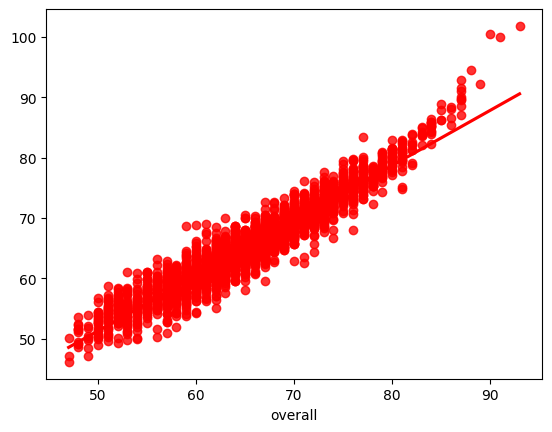

In [47]:
sns.regplot(x=y_test, y=y_pred, ci=None, color='red')

# Difference between Actual and Predicted Values

In [49]:
pred_df = pd.DataFrame({'Actual Value': y_test, 'Predicted Value': y_pred, 'Difference': y_test-y_pred})
pred_df

,Actual Value,Predicted Value,Difference
15024,60,60.992954,-0.992954
11771,64,64.788176,-0.788176
16615,58,57.802653,0.197347
4201,71,70.976365,0.023635
13480,62,62.801663,-0.801663
...,...,...,...
8404,67,66.685955,0.314045
5412,69,69.870322,-0.870322
3755,72,68.860316,3.139684
11886,63,63.927520,-0.927520


In [50]:
# So after Feature selection we can see that the accuracy is bit changed but we are getting nearby predictions. 